In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl
import math
import numpy as np
import networkx as nx
import random as rn
import scipy
import igraph
from matplotlib import colors
import scipy.io as sio

# Data Pipeline for MEG/EEG Functional Brain Networks

The first component of the data pipeline is to read the file into Python from Matlab. The MEG/EEG.fif file is arranged in Matlab is such a way that it saves the data as a large multidimensional array. The data is then saved in Matlab as a .mat file which can then be called into Python in the following manner:

### 1. Read in Data from Matlab and plot single/multi-channel time series

In [102]:
# MEG_DICT = sio.loadmat('ans.mat') # MEG dictionary saved in Matlab - in this case it is closed eye resting state.
# MEG_DATA = MEG_DICT.items() # Accesses the dictionary elements
# single_channel = []
# multi_channel = []

MEG_DICTex1 = sio.loadmat('ans_ex1.mat') # MEG dictionary saved in Matlab - in this case it is closed eye resting state.
MEG_DATAex1 = MEG_DICTex1.items() # Accesses the dictionary elements
single_channelex1 = []
multi_channelex1 = []

MEG_DICTex3 = sio.loadmat('ans_ex3.mat') # MEG dictionary saved in Matlab - in this case it is closed eye resting state.
MEG_DATAex3 = MEG_DICTex3.items() # Accesses the dictionary elements
single_channelex3 = []
multi_channelex3 = []

# The data is read in as a large dictionary of lists. It can be accessed using the appropriate indexes
# Individual channels (sensor - time series) or data points can be accessed with the below indexing calls
# [header][row list][row][entry in row] - must be as shown [1][1][X][Y] 
# 1 is the dictionary key with values that contain all the data.
# 1 is the list of data channels in rows - X is the chosen row and Y is the data point in that row.

# access single channel and all data Y in time series X
# single_channel.extend(MEG_DATA[1][1][0][range(0,1000)])

# # Access multiple channels and select data points in loop
# for i in range(0,10):
#     multi_channel.append(MEG_DATA[1][1][i][range(1,50)])

# access single channel and all data Y in time series X
single_channelex1.extend(MEG_DATAex1[1][1][0][range(0,100)])

# Access multiple channels and select data points in loop
for i in range(0,10):
    multi_channelex1.append(MEG_DATAex1[1][1][i][range(0,20)])
    
    
# access single channel and all data Y in time series X
single_channelex3.extend(MEG_DATAex3[1][1][0][range(0,100)])

# Access multiple channels and select data points in loop
for i in range(0,10):
    multi_channelex3.append(MEG_DATAex3[1][1][i][range(0,20)])
    
    
# Example plots of the time series
# Single channel plot
# plt.plot(single_channelex1)
# plt.show()

# Multi-channel plot
# K = len(multi_channel)
# for j in range(0,K):
#     plt.plot(multi_channel[j])
# plt.show()

# J = len(multi_channelex1)
# for j in range(0,J):
#     plt.plot(multi_channelex1[j])
# plt.show()

# H = len(multi_channelex3)
# for j in range(0,H):
#     plt.plot(multi_channelex3[j])

# print multi_channel[0][0]
# print multi_channelex[0][0]

# plt.plot(single_channel)
# plt.show()
# plt.plot(single_channelex)

# print multi_channelex1

### 2. Channel Analysis of MEG Data

In [104]:
scaled = [[] for x in range(len(multi_channelex1))]
for i in range(len(multi_channelex1)):
    for j in range(0,20):
        scaled[i].append(abs(multi_channelex1[i][j]*10**13))
# print scaled[0]
# print scaled[1]    
tester = [scaled[0], scaled[1], scaled[2], scaled[3]] 
# print tester
#print tester
#print
cov = np.cov(tester)
cov[0][1]
print cov
print
#A = np.matrix([[cov[0][0],cov[0][1]],[cov[1][0],cov[1][1]]])
A = np.matrix(cov)
print A # matrix in numpy form
print
print A.I # Inverse matrix calculator
# multi_channelex1[0]
# multi_channelex1[1]
# plt.plot(scaled)
# plt.show()

[[ 7.54169887  5.58845979  4.41548175  7.46421915]
 [ 5.58845979  6.02105042  4.41725804  6.52798064]
 [ 4.41548175  4.41725804  4.11417717  5.41196943]
 [ 7.46421915  6.52798064  5.41196943  9.24446935]]

[[ 7.54169887  5.58845979  4.41548175  7.46421915]
 [ 5.58845979  6.02105042  4.41725804  6.52798064]
 [ 4.41548175  4.41725804  4.11417717  5.41196943]
 [ 7.46421915  6.52798064  5.41196943  9.24446935]]

[[ 0.69822843 -0.1945979   0.08878552 -0.47832959]
 [-0.1945979   1.01922713 -0.63238886 -0.19238578]
 [ 0.08878552 -0.63238886  1.45115525 -0.47467302]
 [-0.47832959 -0.19238578 -0.47467302  0.90812821]]


### 3. Time series segmentation for functional connectivity (defining the edges)
Here we segment each time series into optimal discreet lengths ready for correlation and inverse covariance estimates

[[ 1.          0.9279832   0.89008813  0.86671627  0.7584915   0.69942906
   0.64614302  0.64303423  0.89727924  0.73716668]
 [ 0.9279832   1.          0.88134119  0.83005242  0.86774961  0.71070566
   0.70142522  0.76025978  0.95486063  0.80423178]
 [ 0.89008813  0.88134119  1.          0.93144036  0.90325111  0.71130134
   0.79554702  0.85704827  0.85220733  0.79626738]
 [ 0.86671627  0.83005242  0.93144036  1.          0.82155969  0.53082455
   0.64485557  0.80698898  0.78592741  0.64787452]
 [ 0.7584915   0.86774961  0.90325111  0.82155969  1.          0.71792448
   0.83572199  0.93735558  0.840434    0.81414715]
 [ 0.69942906  0.71070566  0.71130134  0.53082455  0.71792448  1.
   0.8685682   0.56581053  0.79896538  0.92945048]
 [ 0.64614302  0.70142522  0.79554702  0.64485557  0.83572199  0.8685682
   1.          0.82787729  0.73020195  0.81359396]
 [ 0.64303423  0.76025978  0.85704827  0.80698898  0.93735558  0.56581053
   0.82787729  1.          0.69899138  0.65245088]
 [ 0.8972

C:\Users\owner\Anaconda\lib\site-packages\matplotlib\collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


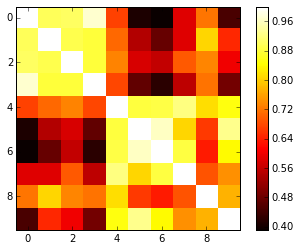

<matplotlib.colorbar.Colorbar instance at 0x0000000009157948>

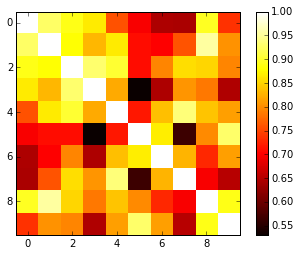

In [17]:
# np.cov - np.corrcoef - scipy.corrcoef - np.linalg.inv

# Correlation matrix check. Using uniform random numbers and computing the correlation, we should fine that 
# there is very small correlation, and that it approaches 0 as the vector length tends to a large N.
# This is what is found in the below test. 

# GRID = [[] for x in xrange(5)]
# for q in range(5):
#     for j in range(0,50):
#         GRID[q].append(rn.uniform(1,10))
# print np.corrcoef(GRID)


# Segmentation variable are defined here. A lower and upper segmentation are defined here and the for-loop iterates through
# the multi-channel list and takes the desired values and allocates them to the SEG_DATA. 

# MIN = 0 # Segmentation start point in current channel
# MAX = 20 # Segmentation end point in current channel
# RANGE = MAX - MIN
# CH_S = 10 # Beginning channel to be iterated over. 
# CH_E = 20 # End channel to be iterated over
# CH_T = CH_E - CH_S
# count = 0 # start value of counter
# SEG_DATA = [[] for x in range(CH_T)]
# LENGTH = len(SEG_DATA)

# for x in range(LENGTH):
#     for y in range(LENGTH):
#         SEG_DATA[x].append(multi_channel[x][y])

# print multi_channelex1
# print multi_channelex3

# SEG_EX1 = [[] for x in range(0,10)]
# SEG_EX3 = [[] for x in range(0,10)]

# count = 0
# for i in range(len(SEG_EX1)):
#     for j in range(count*10,(10+count*10)):
#         SEG_EX1[i].append(multi_channelex1[i][])

# COR = np.corrcoef(multi_channel)
# COV = np.cov(multi_channel)
# INV = np.linalg.inv(COR)

COR1 = np.corrcoef(multi_channelex1)
COR3 = np.corrcoef(multi_channelex3)
# print COR3
# print 
# print COR1
# count = 0
# ITER = 4
# cov = [[] for x in xrange(5)]

# for x in range(ITER):
#     for y in range(5):
#         for z in range(count,count+20):
#             cov[y].append(multi_channel[y][z])
#     count = count + 20
#     COR = np.corrcoef(cov)
#     INV = np.linalg.inv(COR)
#     plasma = plt.get_cmap('hot')
#     cmap2 = mpl.colors.LinearSegmentedColormap.from_list('my_colormap', ['blue','red','black'], 256)
#     img2 = plt.imshow(INV,interpolation='nearest', cmap = plasma)
#     plt.colorbar(img2,cmap=cmap2)
#     plt.show()
#     cov = [[] for x in xrange(5)]

        

# Plot of correlation coefficeint map
plasma = plt.get_cmap('hot')
cmap2 = mpl.colors.LinearSegmentedColormap.from_list('my_colormap', ['blue','red','black'], 256)
img2 = plt.imshow(COR1,interpolation='nearest', cmap = plasma)#origin='lower'
plt.colorbar(img2,cmap=cmap2)
plt.show()
plasma = plt.get_cmap('hot')
cmap2 = mpl.colors.LinearSegmentedColormap.from_list('my_colormap', ['blue','red','black'], 256)
img2 = plt.imshow(COR3,interpolation='nearest', cmap = plasma)#origin='lower'
plt.colorbar(img2,cmap=cmap2)

50


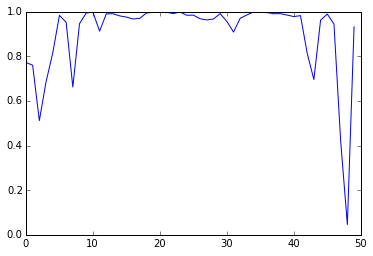

<matplotlib.colorbar.Colorbar instance at 0x000000000F021BC8>

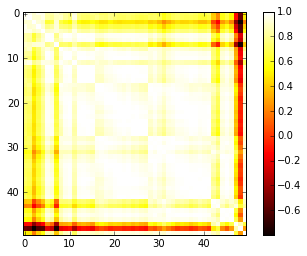

In [97]:
X_matrix = []
X_E = []
Q = []
XX = []
normX = []

QQQ = np.corrcoef(multi_channel)

N = len(multi_channel)

for k in range(0,N):
     X_matrix.append(1)

for c in range(0,10): # Number of iterations
    for i in range(0,N): # Multiply the elements of A with the vector X
        B = QQQ[i]/10**(-11)  # B = row 'i' of Matrix A
        
        for j in range(len(B)): # Iterate throught the elements in B and X and multiply
            Q.append(B[j]*X_matrix[j]) # Append to Q-count array
        X_E.append(sum(Q))      # Sum the Q values, to create element 'i' of new x-vector
        Q = []                  # Clear Q array for next iteration
   
    X_matrix = X_E
    X_E = []
    normX =[]
    for o in range(len(X_matrix)):
        normX.append((1.0*X_matrix[o])/(max(X_matrix)))
    X_matrix = normX
print len(normX)
AAA = []
for i in range(50):
    AAA.append(abs(X_matrix[i]))
plt.plot(AAA)
plt.show()

# Plot of correlation coefficeint map
plasma = plt.get_cmap('hot')
cmap2 = mpl.colors.LinearSegmentedColormap.from_list('my_colormap', ['blue','red','black'], 256)
img2 = plt.imshow(QQQ,interpolation='nearest', cmap = plasma)#origin='lower'
plt.colorbar(img2,cmap=cmap2)